# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Extracting and Analyzing residuals from previous modeling](#Extracting-and-Analyzing-the-residuals-from-previous-modeling)
- [Initial Testing](#Testing)
    - [Shapiro-Wilk Tests](#Shapiro-Wilk-tests)
    - [Breusch-Pagan Test](#Breusch-pagan-Test)
    - [Durbin-Watson Test](#Durbin-watson-test)
- [Solutions](#Solutions)
    - [Adding Ommited features](#Adding-the-Ommited-features)
    - [Enhancing the distribution of new features close to Normal](#Enhancing-the-distribution-of-new-features-close-to-Normal)
    - [transforming target variable](#transforming-target-variable)
- [Removing High Inflential points](#Removing-high-inflential-points)
- [Modeling](#Modeling)    
- [Final Testing](#testing-after-changes)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction
### Regression Analysis: Day 5 - Error Analysis
- This notebook delves into error analysis to gain insights into the nature and distribution of errors in our regression model.

## Importing Libraries

In [26]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [27]:
train_data=pl.read_csv("train_featureEngineered.csv")
test_data=pl.read_csv("test_featureEngineered.csv")
train_data.shape,test_data.shape

((140, 12), (62, 12))

In [28]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

## Extracting and Analyzing the residuals from previous modeling

Mean Train Score: 0.9124030654915102
Standard Deviation of Train Scores: 0.0059883588268930575
Mean Test Score: 0.8726280921957874
Standard Deviation of Test Scores: 0.08551509177106908
Mean absolute Error: 2098.5110591217367
R-squared on holdout set: 0.8100839641672886
Adjusted R-squared on holdout set: 0.7728455257687177


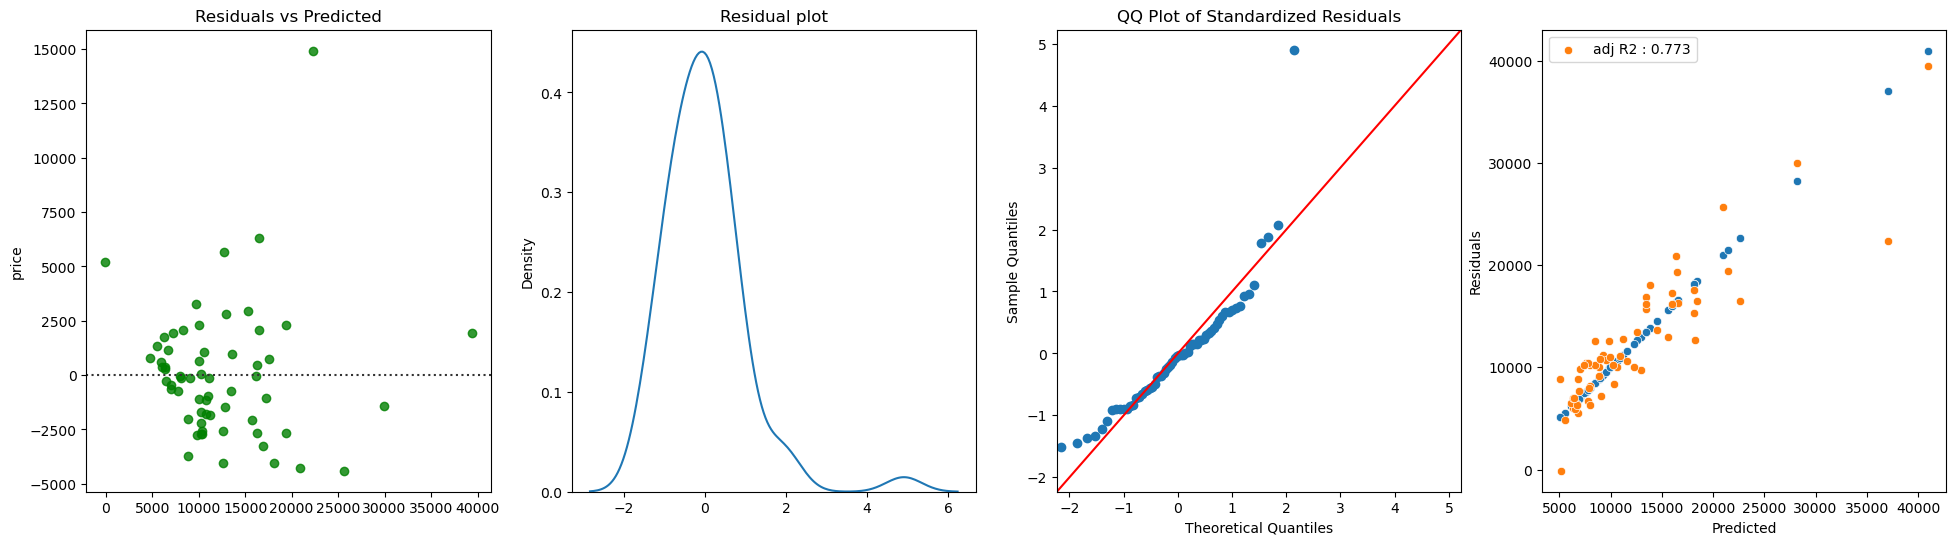

In [29]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_predict,cross_validate,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

elastic_pipe = Pipeline([
    ('imputer', imputer),
    ('regressor', ElasticNet(alpha=0.1566,l1_ratio=.1))
])

rkf=RepeatedKFold(n_splits=10,random_state=42)

elastic_pipe.fit(X_train, y_train)
cv_results = cross_validate(elastic_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(elastic_pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
plt.show()

In [30]:
outliers=np.where(np.std(residuals)*1.7<residuals)[0]
test_data[outliers].hstack(pl.DataFrame(predictions,schema=["predictions"])[outliers])

car_ID,aspiration,carbody,enginetype,fuelsystem,price,carclass,brandavg,carspace,averagempg,performancebalance,enginedisplacement,predictions
i64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
19,"""std""","""hatchback""","""l""","""2bbl""",5151.0,0.0,6435.0,752136.372,49.522863,42306.740826,925.068194,-104.713873
66,"""std""","""sedan""","""ohc""","""mpfi""",18280.0,2.0,10945.0,1.2134e6,21.923077,196676.307692,3153.329317,12721.752286
129,"""std""","""convertible""","""ohcf""","""mpfi""",37028.0,3.0,31964.25,982575.75,19.859813,378488.990971,5626.604306,22329.874822
205,"""turbo""","""sedan""","""ohc""","""mpfi""",22625.0,3.0,18420.0,1.4192e6,21.300448,194144.073244,3156.804245,16461.719603


- 1 obeservation deviating a lot it can porbably a outlier
- car with low price predicted as -ve

## Testing

### Shapiro-Wilk Test: 
- Used to test the normality of the residuals. If the p-value is less than 0.05, the null hypothesis that the data is normally distributed is rejected.

In [31]:
from scipy.stats import shapiro

shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

Shapiro-Wilk test: Statistic=0.8574084043502808, p-value=3.7470879306056304e-06


#### Failed
- Residuals are not normally distributed

### Breusch-Pagan Test: 
- Tests for homoscedasticity (constant variance of the residuals). If the p-value is less than 0.05, the null hypothesis of homoscedasticity is rejected.

In [32]:
X_test_transformed = imputer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=imputer.get_feature_names_out())
# # Add a constant (intercept term)
X_test_transformed = sm.add_constant(X_test_transformed)

In [33]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_test_transformed)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

{'Lagrange multiplier statistic': 29.258670764642286, 'p-value': 0.0036059430635029593, 'f-value': 3.648993746205919, 'f p-value': 0.0006180525856234546}


#### Failed  
- Heteroskedastic residuals present

Logging some features could decrease the Heteroscedastic residuals little bit

### Durbin-Watson Test: 
- Tests for autocorrelation in the residuals. Values close to 2 indicate no autocorrelation, while values deviating significantly from 2 suggest positive or negative autocorrelation.

In [34]:
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson test for autocorrelation
dw_test = durbin_watson(residuals)
print(f"Durbin-Watson test statistic: {dw_test}")

Durbin-Watson test statistic: 1.9453762785711188


#### Passed
- Minute Positive autocorrelation present

### Multi-collinearity test

In [35]:
def condition_index(X):
  if not np.all(X.shape[1] >= 2):
    raise ValueError("Input matrix must have at least two columns.")
  return np.linalg.cond(X)

condition_number = condition_index(imputer.transform(X_train))
print(f"Condition number: {condition_number:.4f}")

Condition number: 10.1416


#### Passed
- very less multicollinearity

## Solutions
- There might be omitted features which could capture heteroskedacity
- Function form of features (ex: feature engineered ones) would be wrong (for heteroskedastic residuals) also
- Transforming the target variable (Right skewed) . Interpretation will not be straight forward

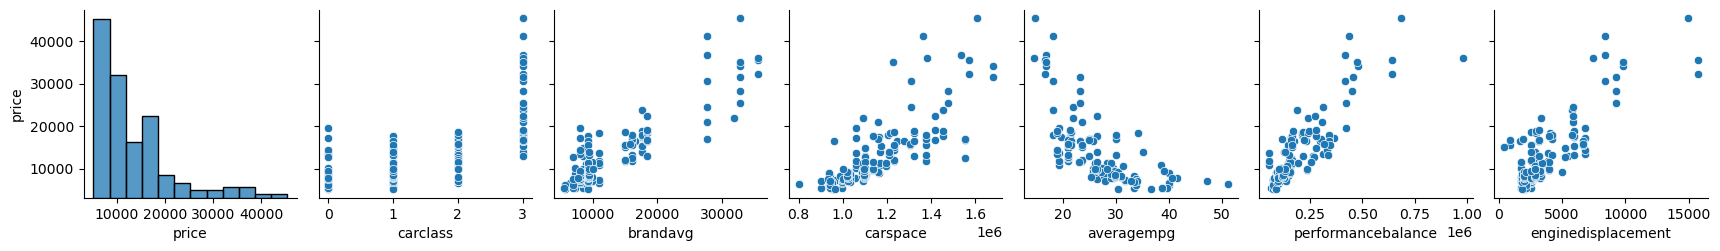

In [36]:
sns.pairplot(train_data.drop("car_ID").to_pandas(),y_vars='price')

### Adding the ommited features

In [37]:
data=pl.read_csv("CarPrice_Assignment.csv")
train_data=train_data.join(data[["car_ID","curbweight","horsepower"]],on="car_ID") # remaining features didn't captured autocorrelation well
test_data=test_data.join(data[["car_ID","curbweight","horsepower"]],on="car_ID")

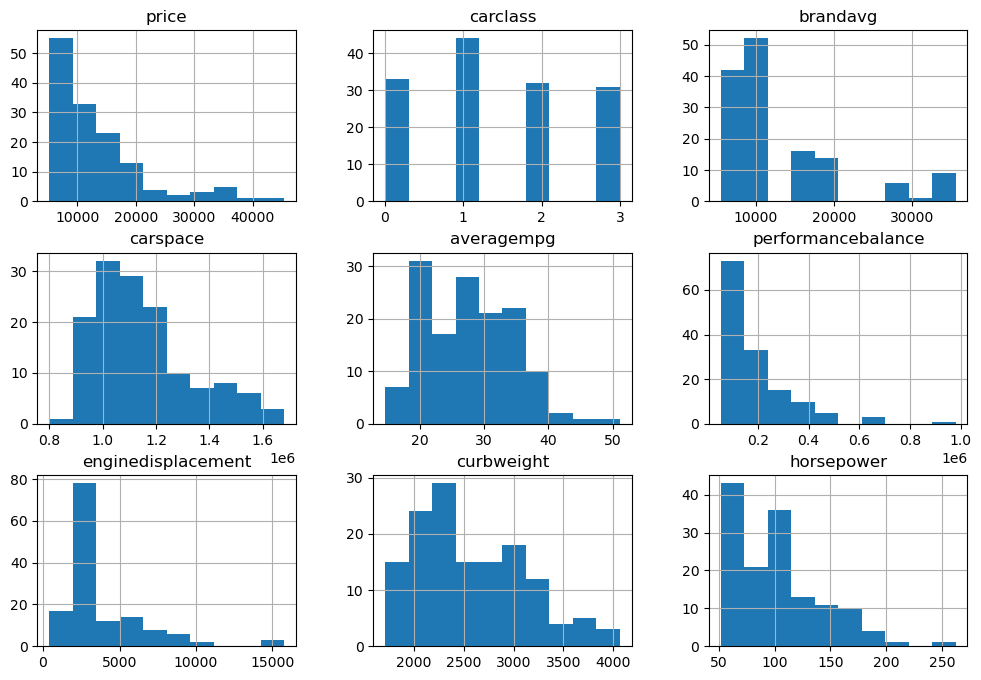

In [38]:
train_data.drop("car_ID").to_pandas().hist(figsize=(12,8))
plt.show()

### Enhancing the distribution of new features close to Normal

In [39]:
# train_data=train_data.with_columns(train_data['curbweight'].log10())
# test_data=test_data.with_columns(test_data['curbweight'].log10())

train_data=train_data.with_columns(train_data['performancebalance'].log10())
test_data=test_data.with_columns(test_data['performancebalance'].log10())

train_data=train_data.with_columns(train_data['enginedisplacement'].log10())
test_data=test_data.with_columns(test_data['enginedisplacement'].log10())

### Transforming Target variable

In [40]:
train_data=train_data.with_columns(train_data['price'].log10())
test_data=test_data.with_columns(test_data['price'].log10())

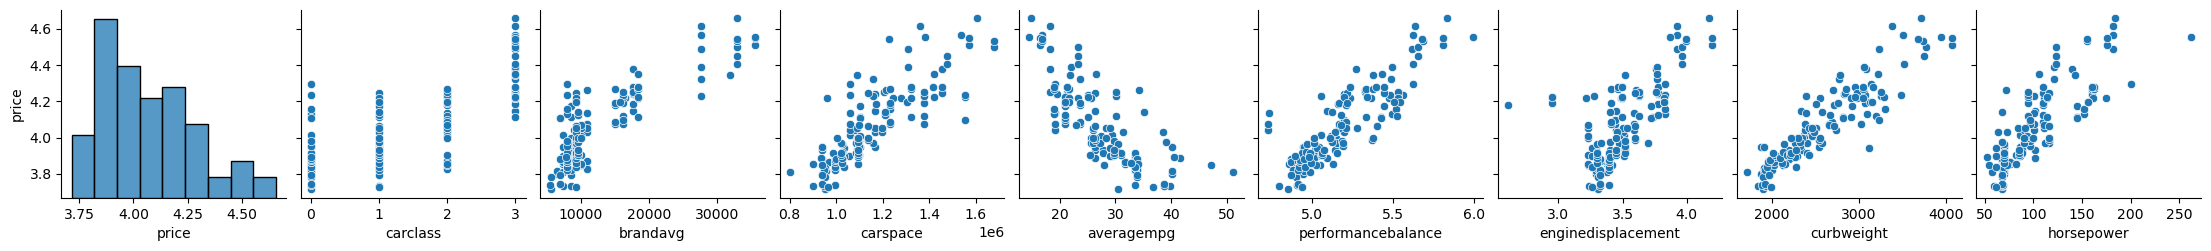

In [41]:
sns.pairplot(train_data.drop("car_ID").to_pandas(),y_vars='price')

## Removing high inflential points

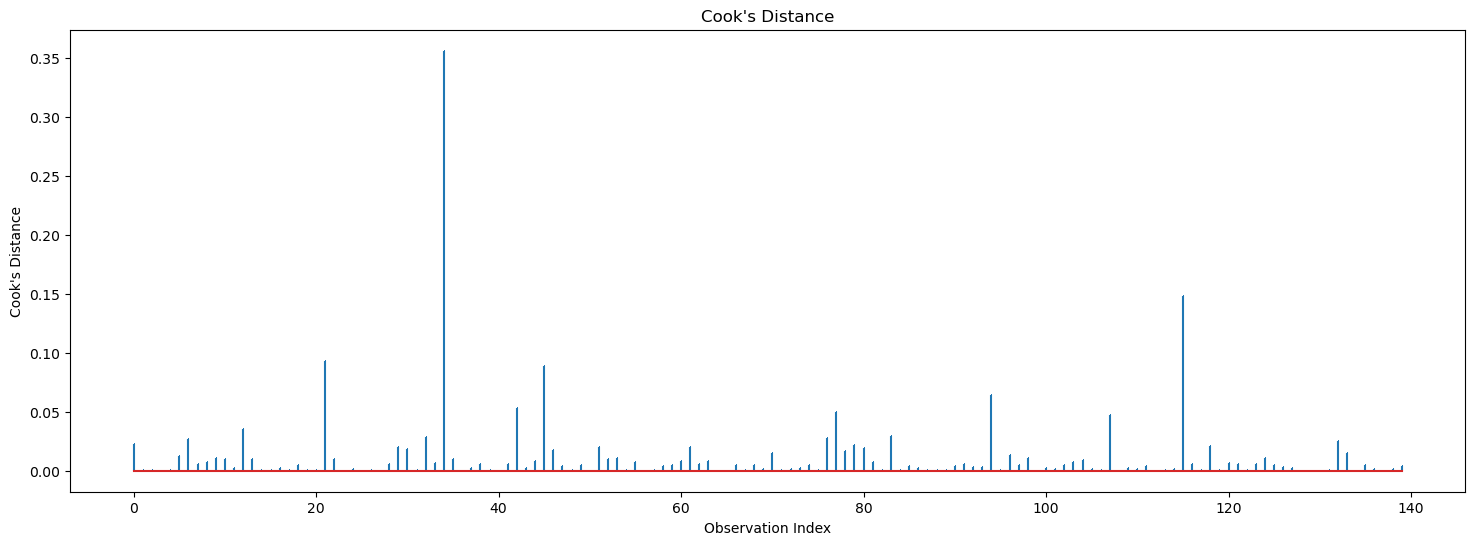

Influential Points: [ 34 115]


In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define the dependent and independent variables
X = train_data.drop("price","car_ID").to_pandas()
y = train_data["price"].to_pandas()
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]
imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
X=imputer.fit_transform(X)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Get influence metrics
influence = model.get_influence()

# Calculate Cook's distance
cooks_d = influence.cooks_distance

# Plot Cook's distance
plt.figure(figsize=(18, 6))
plt.stem(np.arange(len(cooks_d[0])), cooks_d[0], markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()
n_samples = len(y)
influential_points = np.where(cooks_d[0] > 0.1)[0]  # Arbitary
print("Influential Points:", influential_points)

In [43]:
train_data=train_data.filter(~(train_data["car_ID"].is_in(train_data[influential_points]["car_ID"])))

In [44]:
train_data.write_csv("../Day6_improvements/train_errorAnalysed.csv")
test_data.write_csv("../Day6_improvements/test_errorAnalysed.csv")

Having domain knowledge may tune these new features well and know what other features are crucial for car price

Mean Train Score: 0.9438722181473703
Standard Deviation of Train Scores: 0.0032017635665205603
Mean Test Score: 0.9082125308703319
Standard Deviation of Test Scores: 0.05224710945213822
Mean absolute Error: 0.05302162791485415
R-squared on holdout set: 0.8900236976234257
Adjusted R-squared on holdout set: 0.8630907256128361


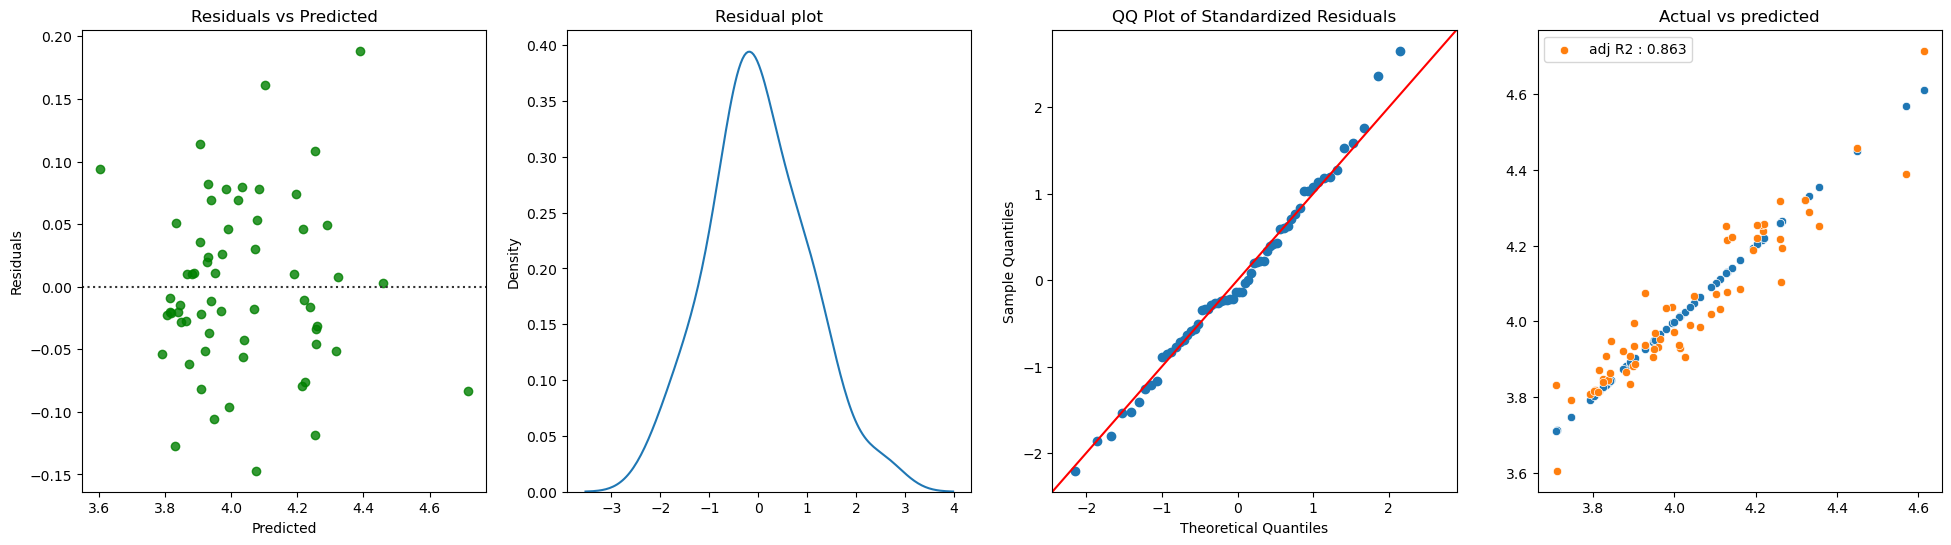

In [54]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_predict,cross_validate,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm
from skopt import BayesSearchCV
from skopt.space import Real

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]
imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

ridge_pipe = Pipeline([
    ('imputer', imputer),
    ('regressor', Ridge())
])
param_space = {
    'regressor__alpha': Real(1e-4, 1e3, prior='log-uniform'),
    # 'regressor__l1_ratio': Real(0, 1)
}
rkf=RepeatedKFold(n_splits=10,random_state=42)
# Initialize the Bayesian search
bayes_search = BayesSearchCV(estimator=ridge_pipe, search_spaces=param_space, n_iter=100, cv=rkf, n_jobs=-1, random_state=42)

# Fit the search
bayes_search.fit(X_train, y_train)

# Get the best hyperparameters
best_alpha = bayes_search.best_params_['regressor__alpha']
# best_l1_ratio = bayes_search.best_params_['regressor__l1_ratio']

# Set the best hyperparameters to the pipeline
ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)

cv_results = cross_validate(ridge_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(ridge_pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.show()

In [56]:
bayes_search.best_params_

OrderedDict([('regressor__alpha', 0.5045604774012459)])

Mean absoulte error on original scale

In [22]:
predictions = cross_val_predict(elastic_pipe, X_test, y_test)
residuals = y_test - predictions
# Sample data (assuming y_test and predictions are in log10 scale)
y_test_transformed = y_test
predictions_transformed = predictions

# Convert predictions back to original scale
y_test_original = 10**y_test_transformed
predictions_original = 10**predictions_transformed

# Calculate the absolute error in the original scale
abs_error_original = np.abs(y_test_original - predictions_original)

# Calculate mean absolute error in the original scale
mae_original = np.mean(abs_error_original)

print("Mean Absolute Error in Original Scale:", mae_original)

Mean Absolute Error in Original Scale: 1653.0431964032584


## Testing After Changes

In [24]:
# Durbin-Watson test for autocorrelation
dw_test = durbin_watson(residuals)
print(f"Durbin-Watson test statistic: {dw_test}")
# Residuals Normailty check
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
# Breusch-Pagan test for Homoscedastic residuals
bp_test = het_breuschpagan(residuals, X_test_transformed)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
# Multi-collinearity
def condition_index(X):
  if not np.all(X.shape[1] >= 2):
    raise ValueError("Input matrix must have at least two columns.")
  return np.linalg.cond(X)

condition_number = condition_index(imputer.transform(X_train))
print(f"Condition number: {condition_number:.4f}")

Durbin-Watson test statistic: 1.7992313412235104
Shapiro-Wilk test: Statistic=0.9891253709793091, p-value=0.8596109747886658
{'Lagrange multiplier statistic': 15.465903642051646, 'p-value': 0.21694057515568, 'f-value': 1.3571218700784762, 'f p-value': 0.21876374324554962}
Condition number: 17.9093


- Autocorrelation increased little
- Residuals are more likely to follow Normal distribution (Some Outliers may present in hold-out Set)
- Strongly Homoscedastic residuals
- No multi-collinearity (little bit increased)

## Results

### Model Performance Summary (Day 5)

#### Cross-Validation Results
- **Mean Train Score**: 0.9439
- **Standard Deviation of Train Scores**: 0.0032
- **Mean Test Score**: 0.9082
- **Standard Deviation of Test Scores**: 0.0522

#### Holdout Set Performance
- **Mean Absolute Error (MAE)**: 0.0530
- **R-squared (R²)**: 0.8900
- **Adjusted R-squared**: 0.8631

### Insights and Comparison with Previous Days

#### Improvements and Changes
- **Consistency**: The mean test score increased significantly from 0.8726 on Day 4 to 0.9082 on Day 5, and the standard deviation of test scores decreased from 0.0855 to 0.0522. This indicates that the model's performance on unseen data has greatly improved and become more consistent.
- **Error Magnitude**: The MAE improved dramatically, decreasing from 2098.5110 on Day 4 to 1653 on Day 5. This substantial reduction in prediction error indicates more accurate model predictions.
- **Holdout Set R²**: The R² on the holdout set increased from 0.8101 on Day 4 to 0.8900 on Day 5, indicating that the model now explains approximately 89.00% of the variance in the holdout data, showcasing a significant improvement in explanatory power.
- **Adjusted R²**: The adjusted R² on the holdout set improved from 0.7728 to 0.8631, suggesting that, accounting for the number of predictors, the model now explains around 86.31% of the variance, a significant increase indicating better performance while considering model complexity.

#### Statistical Tests and Diagnostics
- **Shapiro-Wilk Test**: Initially, the Shapiro-Wilk test showed a statistic of 0.8574 and a p-value of 3.7471e-06, indicating non-normality in the residuals. After adjustments, the statistic improved to 0.9891 with a p-value of 0.8596, suggesting that the residuals are now normally distributed.
- **Breusch-Pagan Test**: Initially, the Lagrange multiplier statistic was 29.2587 with a p-value of 0.0036, indicating heteroscedasticity. After adjustments, the statistic improved to 15.4659 with a p-value of 0.2169, suggesting no significant heteroscedasticity.
- **Durbin-Watson Test**: Initially, the Durbin-Watson statistic was 1.9454, indicating no significant autocorrelation in the residuals. After adjustments, it slightly decreased to 1.7992, which is still within acceptable limits.
- **Condition Number**: Initially, the condition number was 10.1416, suggesting moderate multicollinearity. After adjustments, it increased to 17.9093, indicating some multicollinearity but still within acceptable bounds.

## Conclusion
- Error analysis revealed valuable insights into the model's error distribution, highlighting areas for improvement such as **Heteroscedasticity,NonNormal Residuals**